In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from os.path import expanduser, join
from pandas import read_msgpack
target_folder = expanduser('~/Experiments/spatiotemporal')
nyc_traffic_injury_table = read_msgpack(join(
    target_folder, 'nyc-traffic-injuries.msg-blosc'))
print('nyc_traffic_injury_count = {:,}'.format(len(nyc_traffic_injury_table)))
nyc_traffic_injury_table[:3]

nyc_traffic_injury_count = 201,789


,Longitude,Latitude,Year,Month,Total,Pedestrian,Bike,Vehicle
0,-73.791745,40.725789,2009,1,2,1,0,1
1,-73.882429,40.844981,2009,1,1,1,0,0
2,-73.979058,40.744444,2009,1,2,2,0,0


In [2]:
# Replace integer index with time series index
# Warning! This process is slow (> 100 seconds) and memory hungry
# Press ESC and type 00 if you want to stop and restart
from pandas import Period

def add_period(row):
    row['Period'] = Period(year=row['Year'], month=row['Month'], freq='M')
    return row

nyc_traffic_injury_with_period_table = nyc_traffic_injury_table.apply(
    add_period, axis=1)
nyc_traffic_injury_with_period_table.set_index('Period', inplace=True)
nyc_traffic_injury_with_period_table[:3]

,Longitude,Latitude,Year,Month,Total,Pedestrian,Bike,Vehicle
Period,,,,,,,,
2009-01,-73.791745,40.725789,2009,1,2,1,0,1
2009-01,-73.882429,40.844981,2009,1,1,1,0,0
2009-01,-73.979058,40.744444,2009,1,2,2,0,0


In [ ]:
nyc_traffic_injury_table.to_pickle(join(
    target_folder, 'nyc-traffic-injury.pkl'))
nyc_traffic_injury_with_period_table.to_pickle(join(
    target_folder, 'nyc-traffic-injury-with-period.pkl'))
%ls -lh -S $target_folder

In [ ]:
from pandas import read_pickle

x = nyc_traffic_injury_table
%timeit len(x[(2015 <= x.Year) & (1 <= x.Month) & (x.Year <= 2015) & (x.Month <= 3)])

nyc_traffic_injury_with_period_table = read_pickle(join(
    target_folder, 'nyc-traffic-injury-with-period.pkl'))
%timeit len(nyc_traffic_injury_with_period_table['2015-01':'2015-03'])

In [66]:
# http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases
nyc_traffic_injury_by_year_table = nyc_traffic_injury_with_period_table[[
    'Total', 'Pedestrian', 'Bike', 'Vehicle']].resample('A', np.sum)
nyc_traffic_injury_by_year_table

,Total,Pedestrian,Bike,Vehicle
Period,,,,
2009,46837,11456,3188,32193
2010,48601,11548,3873,33180
2011,45323,11393,3647,30283
2012,44635,10992,3742,29901
2013,45427,11290,3911,30226
2014,41983,10396,3847,27740
2015,39223,8729,3958,26536


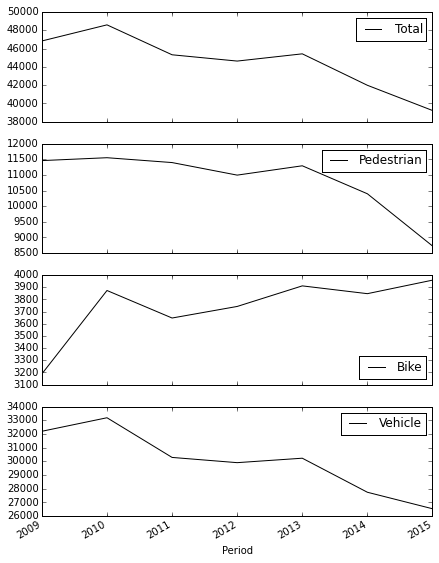

In [99]:
nyc_traffic_injury_by_year_table.plot(subplots=True, figsize=(7, 10));

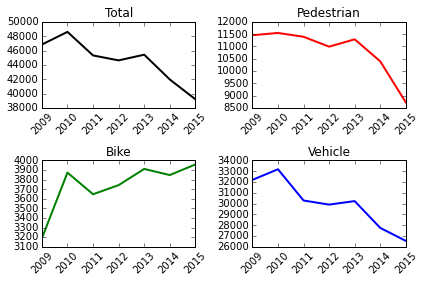

In [100]:
fig = plt.figure()
years = [x.year for x in nyc_traffic_injury_by_year_table.index]
for index, (injury_type, color) in enumerate([
    ('Total', 'k'),
    ('Pedestrian', 'r'),
    ('Bike', 'g'),
    ('Vehicle', 'b'),
], 1):
    ax = plt.subplot(220 + index)
    ax.plot(years, nyc_traffic_injury_by_year_table[injury_type].values, linewidth=2, color=color)
    ax.set_title(injury_type)
    ax.set_xticklabels(years, rotation=45);
fig.tight_layout()

In [123]:
import numpy as np
from collections import OrderedDict

nyc_traffic_injury_by_month_table = nyc_traffic_injury_table.groupby([
    'Year', 'Month',
]).aggregate(OrderedDict([
    ('Pedestrian', np.sum),
    ('Bike', np.sum),
    ('Vehicle', np.sum),
]))
nyc_traffic_injury_by_month_table[:3]

Pedestrian  Bike  Vehicle
Year Month                           
2009 1             957    88     2384
     2             905   128     2073
     3             964   185     2402

In [124]:
f = plt.figure()

In [127]:
f.get_axes()

[]

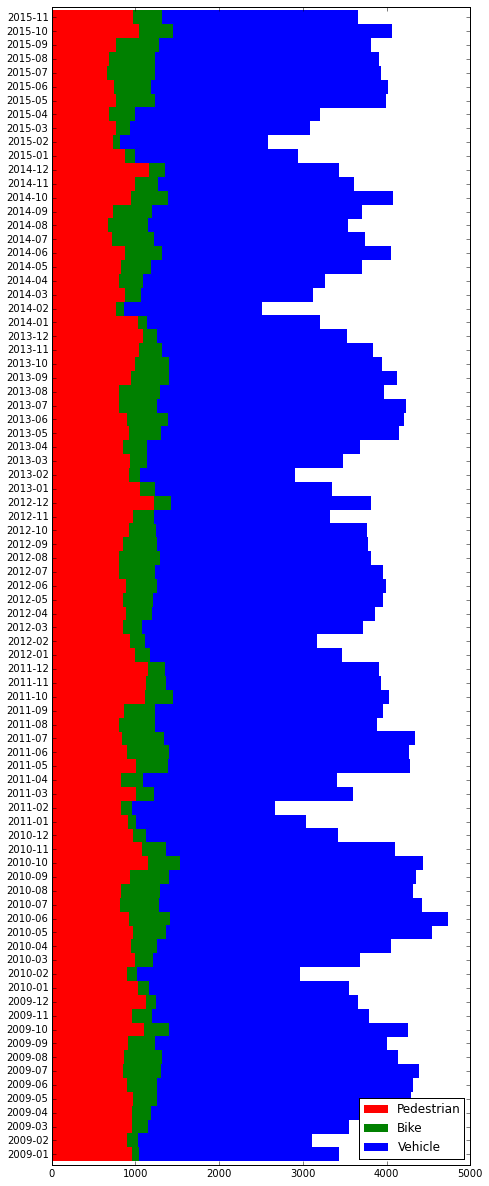

In [148]:
ax = nyc_traffic_injury_by_month_table.plot(
    kind='barh',
    stacked=True,
    color=['r', 'g', 'b'],
    figsize=(7.5, 0.25 * len(nyc_traffic_injury_by_month_table)),
    width=1.01,
    edgecolor='none')
ax.get_yaxis().get_label().set_visible(False) 
ax.set_yticklabels(['%d-%02d' % x for x in nyc_traffic_injury_by_month_table.index]);

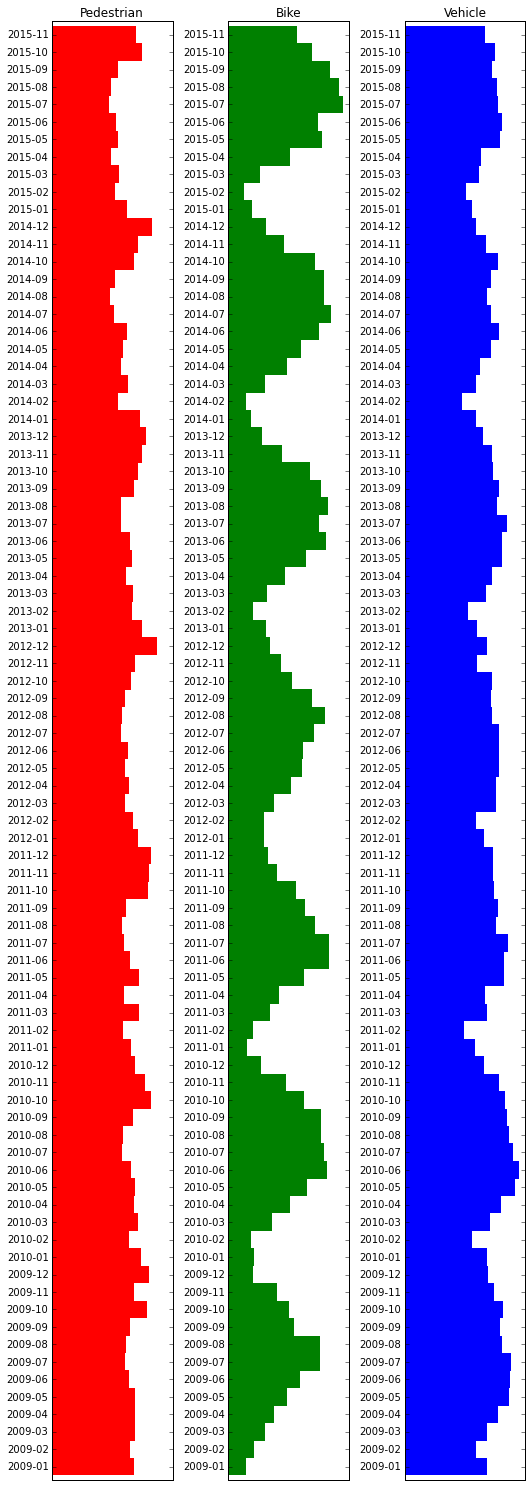

In [149]:
fig = plt.figure()
for index, (injury_type, color) in enumerate([
    ('Pedestrian', 'r'),
    ('Bike', 'g'),
    ('Vehicle', 'b'),
], 1):
    ax = plt.subplot(130 + index)
    ax = nyc_traffic_injury_by_month_table[[injury_type]].plot(
        ax = ax,
        kind='barh',
        color=color,
        figsize=(7.5, 0.25 * len(nyc_traffic_injury_by_month_table)),
        width=1.01,
        edgecolor='none')
    ax.set_title(injury_type)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().get_label().set_visible(False) 
    ax.set_yticklabels(['%d-%02d' % x for x in nyc_traffic_injury_by_month_table.index]);    
    ax.legend().remove()
fig.tight_layout();

In [113]:
from geopy.geocoders import GoogleV3
geocode = GoogleV3().geocode
location = geocode('15 East 79th Street, NY, NY')
xy = location.longitude, location.latitude
xy

(-73.96278819999999, 40.7768885)

In [115]:
from pysal.cg import Arc_KDTree
from pysal.cg.sphere import RADIUS_EARTH_KM

EARTH_RADIUS_IN_METERS = RADIUS_EARTH_KM * 1000
search_radius_in_meters = 100

nyc_traffic_injury_tree = Arc_KDTree(
    nyc_traffic_injury_table[['Longitude', 'Latitude']].values,
    radius=EARTH_RADIUS_IN_METERS)
nyc_traffic_injury_count = nyc_traffic_injury_tree.n
'{:,}'.format(nyc_traffic_injury_count)

'201,789'

In [116]:
# KDTree.query_ball_point does not sort indices
indices = nyc_traffic_injury_tree.query_ball_point(xy, r=search_radius_in_meters)
print(indices)
len(indices)

[83284, 154366, 162003, 198101, 96586, 99343, 104513, 189922, 200233, 4229, 15186, 20508, 35423, 37258, 55836, 57722, 91478, 94299, 96999, 105283, 107209, 126294, 149416, 155558, 157064, 162340, 164521, 172487, 177116, 198454, 5908, 38362, 45509, 64047, 71192, 75640, 80417, 89792, 91992, 94907, 97498, 113932, 124921, 132698, 137415, 144712, 152577, 160649, 165102, 170532, 179342, 183501, 191286]


53

In [117]:
# KDTree.query sorts indices in order of increasing distance
distances, indices = nyc_traffic_injury_tree.query(
    xy, k=75, distance_upper_bound=search_radius_in_meters)
print(distances)
print(indices)
print(len(indices[indices != nyc_traffic_injury_count]))

[ 80.03648092  80.03648092  80.03648092  80.03648092  80.03648092
  80.03648092  80.03648092  80.03648092  80.03648092  80.03648092
  80.03648092  80.03648092  80.03648092  80.03648092  80.03648092
  80.03648092  80.03648092  80.03648092  80.03648092  80.03648092
  80.03648092  84.35950791  84.35950791  84.35950791  84.35950791
  84.35950791  84.35950791  84.35950791  84.35950791  84.35950791
  84.35950791  84.35950791  84.35950791  84.35950791  84.35950791
  84.35950791  84.35950791  84.35950791  84.35950791  84.35950791
  84.35950791  84.35950791  84.35950791  84.35950791  95.24489928
  95.24489928  95.24489928  95.24489928  95.24489928  98.48941227
  98.48941227  98.48941227  98.48941227          inf          inf
          inf          inf          inf          inf          inf
          inf          inf          inf          inf          inf
          inf          inf          inf          inf          inf
          inf          inf          inf          inf          inf]
[  4229  

In [118]:
import numpy as np
selected_nyc_traffic_injury_table = nyc_traffic_injury_table.ix[indices[indices != nyc_traffic_injury_count]]
selected_nyc_traffic_injury_table['Distance'] = distances[distances != np.inf]
selected_nyc_traffic_injury_table[:3]

,Longitude,Latitude,Year,Month,Total,Pedestrian,Bike,Vehicle,Distance
4229,-73.963726,40.777006,2010,1,1,1,0,0,80.036481
15186,-73.963726,40.777006,2009,10,2,2,0,0,80.036481
20508,-73.963726,40.777006,2011,10,1,1,0,0,80.036481


In [119]:
# Nearby
selected_nyc_traffic_injury_table.sort(['Distance', 'Year', 'Month', 'Total'], ascending=[True, False, False, False])[:3]

,Longitude,Latitude,Year,Month,Total,Pedestrian,Bike,Vehicle,Distance
198454,-73.963726,40.777006,2015,10,1,1,0,0,80.036481
177116,-73.963726,40.777006,2015,1,1,1,0,0,80.036481
172487,-73.963726,40.777006,2014,10,1,0,0,1,80.036481


In [120]:
# Recent
selected_nyc_traffic_injury_table.sort(['Year', 'Month', 'Total'], ascending=[False, False, False])[:3]

,Longitude,Latitude,Year,Month,Total,Pedestrian,Bike,Vehicle,Distance
200233,-73.963230,40.777677,2015,11,1,0,0,1,95.244899
198454,-73.963726,40.777006,2015,10,1,1,0,0,80.036481
198101,-73.961628,40.777003,2015,10,1,1,0,0,98.489412


In [122]:
# Worst
from collections import OrderedDict
selected_nyc_traffic_injury_table.groupby(['Longitude', 'Latitude']).aggregate(OrderedDict([
    ('Total', np.sum),
    ('Pedestrian', np.sum),
    ('Bike', np.sum),
    ('Vehicle', np.sum),
])).sort(['Total', 'Pedestrian', 'Bike', 'Vehicle'], ascending=False).reset_index()

,Longitude,Latitude,Total,Pedestrian,Bike,Vehicle
0,-73.963726,40.777006,34,12,2,20
1,-73.962125,40.776320,31,14,3,14
2,-73.963230,40.777677,7,0,1,6
3,-73.961628,40.777003,4,3,1,0
